### exercise 6: beyond linearity 

### task 3: regression and smoothing splines 

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy import stats
from patsy import bs, dmatrix
from matplotlib import pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

In [2]:
Wages = pd.read_csv(r'C:\Users\Chijun Zhang\Documents\jupyter\machine learning exercise\datasets\Wage.csv')
Wages.head()

,Unnamed: 0,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,155159,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,11443,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [3]:
Wages = Wages.rename(columns={'Unnamed: 0': 'id'})
print(pd.isnull(Wages).any())

id            False
year          False
age           False
sex           False
maritl        False
race          False
education     False
region        False
jobclass      False
health        False
health_ins    False
logwage       False
wage          False
dtype: bool


## Regression Splines

In [4]:
design = dmatrix("bs(age, knots=(25,40,60), degree=3, include_intercept=False)", data={"age":Wages.age}, 
                 return_type="dataframe")


model = sm.GLM(endog=Wages.wage, exog=design)
estimate = model.fit()


age_grid = np.linspace(Wages.age.min(), Wages.age.max(), num=1000)
prediction_design = dmatrix("bs(age_grid, knots=(25,40,60), degree=3, include_intercept=False)",
                             {"age_grid": age_grid}, return_type='dataframe')
predictions = estimate.predict(prediction_design)


std_err = np.array([])
for row in prediction_design.values:
    var = np.dot(np.dot(row,estimate.cov_params()), row.T)
    std_err = np.append(std_err,np.sqrt(var))
    

crit_value = stats.t.isf(.05/2,len(Wages)-1)

widths = crit_value*std_err


ui = predictions + widths
li = predictions - widths

In [5]:
design2 = dmatrix("bs(age, df=6, degree=3, include_intercept=False)", data={"age":Wages.age}, return_type='dataframe')


model2 = sm.GLM(endog=Wages.wage, exog=design2)
estimate2 = model2.fit()


prediction2_design = dmatrix("bs(age_grid, df=6, degree=3, include_intercept=False)",
                             {"age_grid": age_grid}, return_type='dataframe')
predictions2 = estimate2.predict(prediction2_design)


std_err2 = np.array([])
for row in prediction2_design.values:
    var = np.dot(np.dot(row,estimate2.cov_params()), row.T)
    std_err2 = np.append(std_err2,np.sqrt(var))
    

crit_value2 = stats.t.isf(.05/2,len(Wages)-1)

widths2 = crit_value*std_err


ui2 = predictions2 + widths2
li2 = predictions2 - widths2

In [6]:
design3 = dmatrix("cr(age, df=4)", data={"age":Wages.age},return_type='dataframe')


model3 = sm.GLM(endog=Wages.wage, exog=design3)
estimate3 = model3.fit()


prediction3_design = dmatrix("cr(age_grid, df=4)", {"age_grid": age_grid},return_type='dataframe')
predictions3 = estimate3.predict(prediction3_design)


std_err3 = np.array([])
for row in prediction3_design.values:
    var = np.dot(np.dot(row,estimate3.cov_params()), row.T)
    std_err3 = np.append(std_err3,np.sqrt(var))
    

crit_value3 = stats.t.isf(.05/2,len(Wages)-1)

widths3 = crit_value*std_err


ui3 = predictions3 + widths3
li3 = predictions3 - widths3

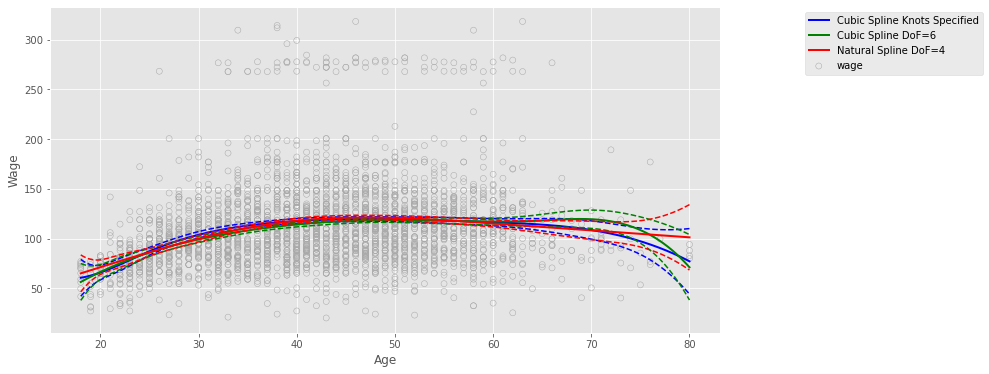

In [7]:
fig, ax = plt.subplots(1,1,figsize=(12,6)) 
ax.scatter(Wages.age, Wages.wage,facecolors='none', edgecolors='darkgray', label="wage");

ax.plot(age_grid, predictions, 'b-', lw=2, label='Cubic Spline Knots Specified');
ax.plot(age_grid, ui, color='b', linestyle='--');
ax.plot(age_grid, li, color= 'b', linestyle='--');

ax.plot(age_grid, predictions2, 'g-', lw=2, label='Cubic Spline DoF=6');
ax.plot(age_grid, ui2, color='g', linestyle='--');
ax.plot(age_grid, li2, color= 'g', linestyle='--');

ax.plot(age_grid, predictions3, 'r-', lw=2, label='Natural Spline DoF=4');
ax.plot(age_grid, ui3, color='r', linestyle='--');
ax.plot(age_grid, li3, color= 'r', linestyle='--');

ax.set_xlabel('Age')
ax.set_ylabel('Wage');
plt.legend(bbox_to_anchor=(1.4, 1.0));

## Smoothing Splines

A smoothing spline is simply a shrunken version of the natural spline so we can obtain similar results using patsy's basis function constructors and statsmodels GLM or OLS classes just as we did above.